In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from collections import Counter

### Read data

In [176]:
raw = pd.read_csv('./5-scalar_mturk_results_round-2.csv')

### Flatten data

In [177]:
data = []
for i,row in raw.iterrows():
    for j in range(1, 13):
        query = row['Input.q%d' % j]
        response = row['Input.r%d' % j]
        gender = row['Input.g%d' % j]
        
        if row['Answer.answer%d' % j] is not np.nan:
            answer = row['Answer.answer%d' % j]
        else:
            answer = row['Answer.answer%d.label' % j]
        
        data.append((row['HITId'], j, row['WorkerId'], gender, query, response, answer))

In [178]:
melted = pd.DataFrame(data)
melted.columns = ['HITId', 'q_idx', 'WorkerId', 'gender', 'query', 'response', 'answer']
melted.head(1)

,HITId,q_idx,WorkerId,gender,query,response,answer
0,3TUOHPJXYHY69M5C7LE07UKMJ6CXWR,1,A1ZDR2UN7M92LI,M,What exactly do these restrictions look like?,"You can't play in the finals, and you have to ...",Very helpful


In [179]:
# include spammers:
include = False
if not include:
    spammers = ['AKGUW9H0O6CDA', 'AOADA34ZQHEUB', 'A1CEO8RFPXMO5W']
    melted = melted[~melted.WorkerId.isin(spammers)].copy()

In [165]:
data = []
for i, group in melted.groupby(['HITId', 'q_idx']):
    row = []
    row.append(group.iloc[0]['HITId'])
    row.append(group.iloc[0]['gender'])
    row.append(group.iloc[0]['query'])
    row.append(group.iloc[0]['response'])
    for j in range(0,2):
        if j < len(group):
            row.append(group.iloc[j]['WorkerId'])
            row.append(group.iloc[j]['answer'])
    data.append(row)

In [145]:
flat = pd.DataFrame(data)
flat.columns = ['HITId', 'gender', 'query', 'response'] + \
    sum([ ['WorkerId%d' % i, 'answer%d' % i] for i in range(0,2) ], [])

ValueError: Length mismatch: Expected axis has 6 elements, new values have 8 elements

In [146]:
flat.head(1)

,0,1,2,3,4,5
0,371DNNCG443O240A48XX4BWUO3LT8P,W,Whats the plan for spending time with in-laws?,"Well, I'm going to be spending time with them ...",A1CEO8RFPXMO5W,Very helpful


### Collapse labels

In [166]:
flat.answer0.unique()

AttributeError: 'DataFrame' object has no attribute 'answer0'

In [180]:
def mapping(x):
    if type(x) == str:
        x = x.lower()
        l = ['very helpful', 'helpful', 'neutral', 'unhelpful', 'very unhelpful']
        return 4 - l.index(x)
    else:
        print('error')
        return 2

In [181]:
melted['scale'] = melted.answer.apply(lambda x: mapping(x))

error


### Analysis

In [182]:
groups = melted.groupby('gender').scale.mean()
print(groups)
difference = groups['W'] - groups['M']
print(difference)

gender
M    2.996914
W    3.003086
Name: scale, dtype: float64
0.006172839506172423


In [174]:
melted.std()['scale']

nan

##### Plot

<AxesSubplot:xlabel='gender', ylabel='scale'>

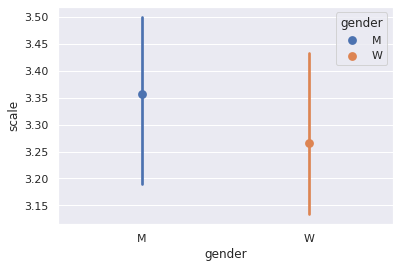

In [153]:
sns.pointplot(x='gender', y='scale', data=melted, hue='gender')

##### t-test

In [154]:
from scipy.stats import ttest_ind
groups = list(melted.groupby('gender'))
m_group, w_group = groups[0], groups[1]
ttest_ind(m_group[1]['scale'], w_group[1]['scale'])

Ttest_indResult(statistic=0.7567722228400449, pvalue=0.4517259936898239)

##### Number of workers

/nas/home/jwei/anaconda3/envs/notebook/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AOADA34ZQHEUB     48
A1CEO8RFPXMO5W    12
AKGUW9H0O6CDA     12
Name: WorkerId, dtype: int64

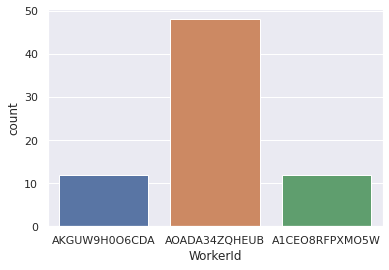

In [155]:
sns.countplot(melted['WorkerId'], orient='h')
melted['WorkerId'].value_counts()

<AxesSubplot:xlabel='scale', ylabel='WorkerId'>

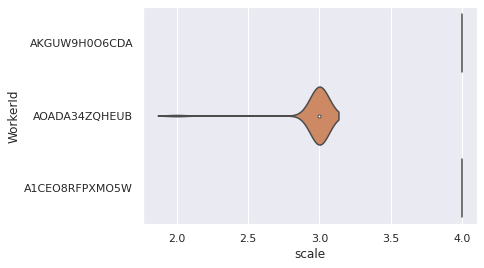

In [156]:
sns.violinplot(y='WorkerId', x='scale', data=melted)

In [119]:
melted['WorkerId'].value_counts()

A3A0RP6IUR41PP    300
A1I66SKK9RFQSA    156
A358FO4TSP07H      72
A16MUTJUTF8VBF     60
AOADA34ZQHEUB      48
AKGUW9H0O6CDA      12
A1CEO8RFPXMO5W     12
ARPBDM5QZ4XQC      12
A1ZDR2UN7M92LI     12
A35GVG1B0TGRXA     12
AKDT74PI2WSIG      12
AEQAECZ7YG5LO      12
Name: WorkerId, dtype: int64

##### pooled variance

In [120]:
import random
flat['scale0'] = flat.answer0.apply(lambda x: mapping(x))
flat['scale1'] = flat.answer1.apply(lambda x: mapping(x) + random.uniform(0,0.4))
flat.head(1)

error
error


,HITId,gender,query,response,WorkerId0,answer0,WorkerId1,answer1,scale0,scale1
0,308KJXFUJR72LSTP16HB022PERLTAT,M,What if the Spurs land LeBron?,I think the Spurs are trying to get him.,A3A0RP6IUR41PP,Very helpful,A1I66SKK9RFQSA,Helpful,4,3.005777


<AxesSubplot:xlabel='scale0', ylabel='scale1'>

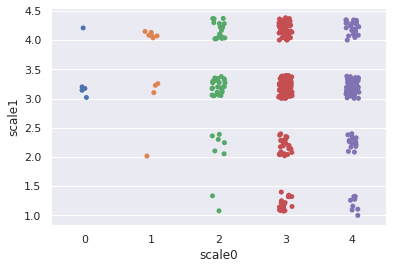

In [121]:
sns.stripplot(data=flat, x='scale0', y='scale1')

In [122]:
pooled_var = np.mean(np.sqrt(flat['scale0'] - flat['scale1']))
np.sqrt(pooled_var)

/nas/home/jwei/anaconda3/envs/notebook/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.025940147693396